In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import pickle

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb

from sklearn.metrics import log_loss

import treeinterpreter

# Goals of this notebook

The previous notebook covered a lot of information about building a machine learning model. We carefully analyzed and featurized our data, created train, validation and test datasets, introspected into our model to see what it was doing, learned about standard scaling, precision, recall, one-hot encoding and grid search.

Today, we'll see the power of tree-based techniques and how they remove the need for a lot of preprocessing we had to do yesterday.

Instead of reading in the files we created earlier this week, let's start from scratch.

### Read data - ignore cross-validation for now

In [4]:
DATA_PATH = "../data/walmart"
TRAIN_PATH = f"{DATA_PATH}/train.csv"
TEST_PATH = f"{DATA_PATH}/test.csv"

In [5]:
#create dataframes for each set
df = pd.read_csv(TRAIN_PATH) #read file again in case we did some operations that could cause leakage (fill nulls etc.)

#### Fill nulls

In [6]:
df.isnull().sum(axis=0)

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64

In [7]:
df['Upc'].fillna(-1, inplace=True)
df['DepartmentDescription'].fillna("-1", inplace=True)
df['FinelineNumber'].fillna(-1, inplace=True)

In [8]:
df.isnull().sum(axis=0)

TripType                 0
VisitNumber              0
Weekday                  0
Upc                      0
ScanCount                0
DepartmentDescription    0
FinelineNumber           0
dtype: int64

**Note**: if we were filling nulls in a more complex way, for example by replacing nulls by median values or most frequent (mode) values, then we would have to ensure we only used the median/mode from the train set. But since we are just using a generic constant value, it doesn't matter.

### Simple model - predict trip type based on each ITEM not each VISIT!

#### Replace non-numerical values by integers

In [9]:
df.head() #make sure that you don't visit number as a feature

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [10]:
#convert certain cols to categories

df['Weekday'] = df['Weekday'].astype('category')
df['DepartmentDescription'] = df['DepartmentDescription'].astype('category')

In [11]:
df['Weekday'].cat.categories

Index(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object')

In [12]:
df['Weekday'].cat.codes.head()

0    0
1    0
2    0
3    0
4    0
dtype: int8

In [13]:
df_weekday_orig = df['Weekday'].copy()
df_department_orig = df['DepartmentDescription'].copy()

In [14]:
df['Weekday'] = df['Weekday'].cat.codes
df['DepartmentDescription'] = df['DepartmentDescription'].cat.codes

In [15]:
df.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,0,6.811315e+10,-1,21,1000.0
1,30,7,0,6.053882e+10,1,63,8931.0
2,30,7,0,7.410811e+09,1,51,4504.0
3,26,8,0,2.238404e+09,2,50,3565.0
4,26,8,0,2.006614e+09,2,50,1017.0


**Question**: Write a test to ensure you did a 1-1 mapping from string values -> numeric values

In [16]:
#duplicates would result in multiple rows for the weekday or for the integer values
pd.concat([df_weekday_orig, df['Weekday']], axis=1).drop_duplicates()

,Weekday,Weekday
0,Friday,0
19949,Saturday,2
43565,Sunday,3
70659,Monday,1
91099,Tuesday,5
108497,Wednesday,6
126017,Thursday,4


In [17]:
#number of rows in table mapping departments -> integers
#duplicates would introduce rows like:
#department1 -> 0, department1 -> 1 OR department1 -> 0, department2 -> 0
print(pd.concat([df_department_orig, df['DepartmentDescription']], axis=1).drop_duplicates().shape)

#number of unique departments
print(len(df['DepartmentDescription'].unique()))

(69, 2)
69


#### Alternate method:

Note we are being more careful with the code below to give a more realistic example of how code in Jupyter would be written to a library. We won't be using the function below further in this notebook.

In [18]:
def categorical_to_integer(df: pd.DataFrame, colname: str, cat_to_int:dict = {}, int_to_cat:dict = {}) -> (dict, dict):
    unique_values = df[colname].unique()
    N_unique_values = len(unique_values)

    
    if colname in cat_to_int: 
        raise ValueError("Already processed this column")
    cat_to_int[colname] = dict(zip(unique_values, np.arange(N_unique_values)))
    
    if colname in int_to_cat:
        raise ValueError("Already processed this column")
    int_to_cat[colname] = dict(zip(np.arange(N_unique_values), unique_values))
    
    return cat_to_int, int_to_cat

In [19]:
cat_to_int, int_to_cat = {}, {}
cat_to_int, int_to_cat = categorical_to_integer(df, "Weekday", cat_to_int, int_to_cat)

In [20]:
cat_to_int

{'Weekday': {0: 0, 2: 1, 3: 2, 1: 3, 5: 4, 6: 5, 4: 6}}

In [21]:
int_to_cat

{'Weekday': {0: 0, 1: 2, 2: 3, 3: 1, 4: 5, 5: 6, 6: 4}}

Now we can use these dictionaries and pd.DataFrame.apply to map the names to integers.

#### End of alternate method

Our dataframe now has numeric values for Weekday and DepartmentDescription

In [22]:
df.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,0,6.811315e+10,-1,21,1000.0
1,30,7,0,6.053882e+10,1,63,8931.0
2,30,7,0,7.410811e+09,1,51,4504.0
3,26,8,0,2.238404e+09,2,50,3565.0
4,26,8,0,2.006614e+09,2,50,1017.0


In [23]:
df['DepartmentDescription'].head(10)

0    21
1    63
2    51
3    50
4    50
5    50
6    50
7    50
8    50
9    50
Name: DepartmentDescription, dtype: int8

In [24]:
print(df_department_orig.cat.categories[21])
print(df_department_orig.cat.categories[63])
print(df_department_orig.cat.categories[51])
print(df_department_orig.cat.categories[50])

FINANCIAL SERVICES
SHOES
PERSONAL CARE
PAINT AND ACCESSORIES


In [25]:
df_department_orig.head(10)

0       FINANCIAL SERVICES
1                    SHOES
2            PERSONAL CARE
3    PAINT AND ACCESSORIES
4    PAINT AND ACCESSORIES
5    PAINT AND ACCESSORIES
6    PAINT AND ACCESSORIES
7    PAINT AND ACCESSORIES
8    PAINT AND ACCESSORIES
9    PAINT AND ACCESSORIES
Name: DepartmentDescription, dtype: category
Categories (69, object): [-1, 1-HR PHOTO, ACCESSORIES, AUTOMOTIVE, ..., SPORTING GOODS, SWIMWEAR/OUTERWEAR, TOYS, WIRELESS]

### Ready for one first tree-based model?!

In [26]:
model = RandomForestClassifier(n_estimators=10, max_depth=None, n_jobs=-1)

In [27]:
model.fit(df.drop(['VisitNumber', 'TripType'], axis=1), df['TripType'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [28]:
pred = model.predict(df.drop(['VisitNumber', 'TripType'], axis=1))
pred_proba = model.predict_proba(df.drop(['VisitNumber', 'TripType'], axis=1))

In [29]:
print(pred[0:10])

[999 999  39  26  26  26   9  26  26  26]


In [30]:
print(pred_proba[0:5, :])
print(pred_proba.shape)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         1.        ]
 [0.         0.         0.         0.         0.         0.
  0.18166667 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.295      0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.15166667 0.         0.         0.
  0.         0.37166667]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.36

In [31]:
accuracy = (df['TripType']==pred).sum() / df.shape[0]
print(f'accuracy = {accuracy}')

accuracy = 0.546206344447295


In [32]:
multi_log_loss = log_loss(df['TripType'].tolist(), pred_proba)
print(f'log loss = {multi_log_loss}')

log loss = 1.1929166742361499


**Notes**:

1. We are probably overfitting here given we didn't do cross-validation (and set max_depth to be arbitrary). We should extend this analysis to our train and val sets.

2. Even with the caveats in (1), this should shock you! We literally filled some null values, replaced some strings by integers and trained a model that predicts the trip type based on ONE product for each row and get reasonable performance. Let's explore the distribution of predictions for each visit number.

In [33]:
df['pred'] = pred

Text(0, 0.5, 'Number of unique predictions / Number of rows for a visit')

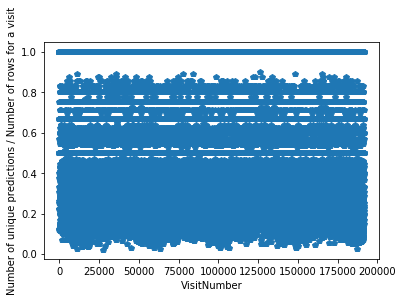

In [34]:
plt.plot(df.groupby('VisitNumber').agg({'pred': lambda x: len(np.unique(x)) / len(x)})['pred'].sort_values(), 'p')
plt.xlabel('VisitNumber')
plt.ylabel('Number of unique predictions / Number of rows for a visit')

The x-axis here is one value per visit number. The y-axis is the number of different predictions the random forest made for each trip (since we have one row per product not one row per visit). A value of 1 means each row in a particular visit was predicted to be a different trip type. A lower value means the model predicted almost the same trip type for every row.

Let's pick the most frequent value for each visit number and re-compute accuracy and log loss.

In [35]:
pred_mostfrequent = df.groupby('VisitNumber').agg({'pred': lambda x: np.argmax(np.bincount(x))})

In [36]:
target = df[['VisitNumber', 'TripType']].drop_duplicates().set_index('VisitNumber')

In [37]:
pred_mostfrequent.head()

,pred
VisitNumber,
5,999
7,39
8,26
9,37
10,40


In [38]:
target.head()

,TripType
VisitNumber,
5,999
7,30
8,26
9,8
10,8


In [39]:
comp = pd.concat([pred_mostfrequent, target], axis=1)
print(comp.head())

             pred  TripType
VisitNumber                
5             999       999
7              39        30
8              26        26
9              37         8
10             40         8


In [40]:
accuracy = (comp['pred']==comp['TripType']).sum() / comp.shape[0]
print(accuracy)

0.6772686414281832


This simple heuristic of picking the most frequent prediction for a visit based on the predictions for each individual item led to an increase in accuracy from ~55% to ~68%.

**WARNING**: Throughout this process, there should be a warning flag in your head saying "do cross-validation, do cross-validation". Why then am I still going on without it?

1. To keep the start of this notebook simple to illustrate our featurization ideas.

2. To get a sense of how things change **relatively** when we make certain changes. It is an avenue to assess potentially useful ideas that might or might not stand up to closer scrutiny. This idea of picking the most frequent prediction might end up not working as well when we do full cross-validation but it is still a potentially valuable idea.

We also want to calculate log loss using this most frequent technique. But how should we do it? Unlike with accuracy, we cannot simply pick the most frequent prediction since we need probabilities. We picked a simple procedure:

* For a visit, pick the most frequent label (pred_mostfrequent in comp above)

* Pick all the probability predictions for the rows where the most frequent label was predicted for a fixed visit number.

* Average these probabilities

This is a heuristic - there's no deep reason for it.

In [41]:
df.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,pred
0,999,5,0,6.811315e+10,-1,21,1000.0,999
1,30,7,0,6.053882e+10,1,63,8931.0,999
2,30,7,0,7.410811e+09,1,51,4504.0,39
3,26,8,0,2.238404e+09,2,50,3565.0,26
4,26,8,0,2.006614e+09,2,50,1017.0,26


We already have "pred" in our dataframe (we manually appended it). Let's add the most frequent pred here too.

In [42]:
pred_mostfrequent

,pred
VisitNumber,
5,999
7,39
8,26
9,37
10,40
...,...
191343,25
191344,22
191345,39


In [43]:
pred_mostfrequent.columns = ["pred_mostfrequent"]

In [44]:
df_mostfrequent = pd.merge(df, pred_mostfrequent.reset_index(), how="left", on="VisitNumber")

In [45]:
#some checks
assert(df.shape[0] == df_mostfrequent.shape[0])

In [46]:
df_mostfrequent.head(20)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,pred,pred_mostfrequent
0,999,5,0,6.811315e+10,-1,21,1000.0,999,999
1,30,7,0,6.053882e+10,1,63,8931.0,999,39
2,30,7,0,7.410811e+09,1,51,4504.0,39,39
3,26,8,0,2.238404e+09,2,50,3565.0,26,26
4,26,8,0,2.006614e+09,2,50,1017.0,26,26
5,26,8,0,2.006619e+09,2,50,1017.0,26,26
6,26,8,0,2.006614e+09,1,50,1017.0,9,26
7,26,8,0,7.004803e+09,1,50,2802.0,26,26
8,26,8,0,2.238495e+09,1,50,4501.0,26,26
9,26,8,0,2.238400e+09,-1,50,3565.0,26,26


**Question**: As usual, add some checks to ensure we didn't make a mistake in this join.

In [47]:
#check that the pred column is the same as pred before the join

print((df['pred']!=df_mostfrequent['pred']).sum())

0


**Question**: Recompute the most-frequent accuracy using the "pred_mostfrequent" column and ensure you get the same answer as before

In [48]:
comp = df_mostfrequent[['VisitNumber', 'pred_mostfrequent']].drop_duplicates()

In [49]:
comp.head()

,VisitNumber,pred_mostfrequent
0,5,999
1,7,39
3,8,26
26,9,37
29,10,40


In [50]:
comp.set_index('VisitNumber', inplace=True)
comp.head()

,pred_mostfrequent
VisitNumber,
5,999
7,39
8,26
9,37
10,40


In [51]:
target.head()

,TripType
VisitNumber,
5,999
7,30
8,26
9,8
10,8


In [52]:
comp['target'] = target #adding a column like this uses the index to match rows. this should create a problem

In [53]:
comp.head()

,pred_mostfrequent,target
VisitNumber,,
5,999,999
7,39,30
8,26,26
9,37,8
10,40,8


In [54]:
(comp['pred_mostfrequent']==comp['target']).sum() / comp.shape[0]

0.6772686414281832

So we now have the dataframe df_mostfrequent.

**Question**: Can you think of a way of using this to carry out our procedure for the log loss computation described above?

In [55]:
df_mostfrequent = df_mostfrequent[df_mostfrequent['pred']==df_mostfrequent['pred_mostfrequent']]

**Warning**: One of the pitfalls of notebooks is when we re-use variable like the one above. After the assignment, df_mostfrequent is a subset of the original df_mostfrequent. It's sometimes okay to do this if the variable is not going to be outside a small section of the notebook and if it helps prevent a profileration of names that one has to keep track of in one's head. But, generally be careful since running cells out of order can cause silent failures when variables are re-assigned to.

In [56]:
df_mostfrequent['proba'] = pred_proba[df_mostfrequent.index, :].tolist()

In [57]:
df_mostfrequent.iloc[0]

TripType                                                               999
VisitNumber                                                              5
Weekday                                                                  0
Upc                                                            6.81132e+10
ScanCount                                                               -1
DepartmentDescription                                                   21
FinelineNumber                                                        1000
pred                                                                   999
pred_mostfrequent                                                      999
proba                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: 0, dtype: object

 **Question**: Ensure all the elements in the probability vector add up to 1.

In [58]:
#can use np.isclose to enforce tolerances due to rounding errors
assert(df_mostfrequent['proba'].apply(lambda x: np.sum(x)).unique()[0] == 1)

**Question**: Now compute the average probability vector for each visit. Is the average of probability distributions a probability distribution?

In [59]:
#example
np.sum(np.vstack(df_mostfrequent[df_mostfrequent['VisitNumber']==7]['proba'].tolist()), axis=0)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.36666667, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.1       , 0.        ,
       0.        , 0.53333333, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [60]:
df_mostfrequent[df_mostfrequent['VisitNumber']==7].groupby('VisitNumber').agg({'proba': lambda x: list(np.sum(np.vstack(x.tolist()),axis=0))})

,proba
VisitNumber,
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [61]:
mean_pred_proba = df_mostfrequent.groupby('VisitNumber').agg({'proba': lambda x: list(np.sum(np.vstack(x.tolist()),axis=0))})                                                            

**Question**: Ensure that all the proba vectors have the same length (38 = number of classes)

In [62]:
mean_pred_proba['proba'].apply(len).unique()

array([38])

In [63]:
mean_pred_proba.head()

,proba
VisitNumber,
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,"[0.0, 0.0, 0.2, 0.0, 0.0, 0.1119047619047619, ..."
9,"[0.0, 0.0, 0.03747478948154944, 0.0, 0.0508348..."
10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.2239804923337532, ..."


In [64]:
target.head()

,TripType
VisitNumber,
5,999
7,30
8,26
9,8
10,8


In [65]:
target.shape

(95674, 1)

In [66]:
mean_pred_proba.shape

(95674, 1)

In [67]:
mean_pred_proba['TripType'] = target['TripType']

In [68]:
mean_pred_proba.head()

,proba,TripType
VisitNumber,,
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",999
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",30
8,"[0.0, 0.0, 0.2, 0.0, 0.0, 0.1119047619047619, ...",26
9,"[0.0, 0.0, 0.03747478948154944, 0.0, 0.0508348...",8
10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.2239804923337532, ...",8


In [69]:
log_loss(mean_pred_proba['TripType'], mean_pred_proba['proba'].tolist())

1.1600960966169218

Our average loss per row improved from 1.19 when we treated each product for a visit as an independent row to 1.16 when we averaged the most frequent prediction's probability vectors.

## Summary till now:

We took the path of least resistance to quickly build a model using a random forest. The only preprocessing done was to fill null values and replace string values by integer values. Unlike in linear models, where the order in which, say days are assigned to integers 0 through 6 makes a massive difference, random forests have no problems dealing with such encodings as we'll see below.

What we should really do at this stage is to do our cross-validation carefully but instead, we'll look at just the train set and get more intuition about decision trees and random forests.

In [70]:
df.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,pred
0,999,5,0,6.811315e+10,-1,21,1000.0,999
1,30,7,0,6.053882e+10,1,63,8931.0,999
2,30,7,0,7.410811e+09,1,51,4504.0,39
3,26,8,0,2.238404e+09,2,50,3565.0,26
4,26,8,0,2.006614e+09,2,50,1017.0,26


In [71]:
model = RandomForestClassifier(n_estimators=10,
                               criterion='gini',
                               max_depth=4,
                               min_samples_split=2,
                               min_samples_leaf=1,
                               max_features='auto',
                               bootstrap=True,
                               oob_score=False,
                               n_jobs=None,
                               random_state=None,
                               verbose=10,
                               class_weight=None
                               )

I picked a few of the arguments to the random forest constructor that are important to discuss.

In [72]:
model.fit(df.drop(['VisitNumber', 'TripType'], axis=1), df['TripType'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 10


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


building tree 4 of 10


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


building tree 5 of 10


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s remaining:    0.0s


building tree 6 of 10


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.6s remaining:    0.0s


building tree 7 of 10


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.8s remaining:    0.0s


building tree 8 of 10


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.0s remaining:    0.0s


building tree 9 of 10


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.4s remaining:    0.0s


building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.7s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=10, warm_start=False)

A forest is a **collection of trees**

In [73]:
model.base_estimator

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [74]:
model.estimators_

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                        max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=371285217, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                        max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=44739803, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                        max_features='auto', max_leaf_nodes=None,
                        min_i

In [75]:
model.estimators_[0]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=371285217, splitter='best')

We can visualize the decision made by each tree

/home/sanjay/.local/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


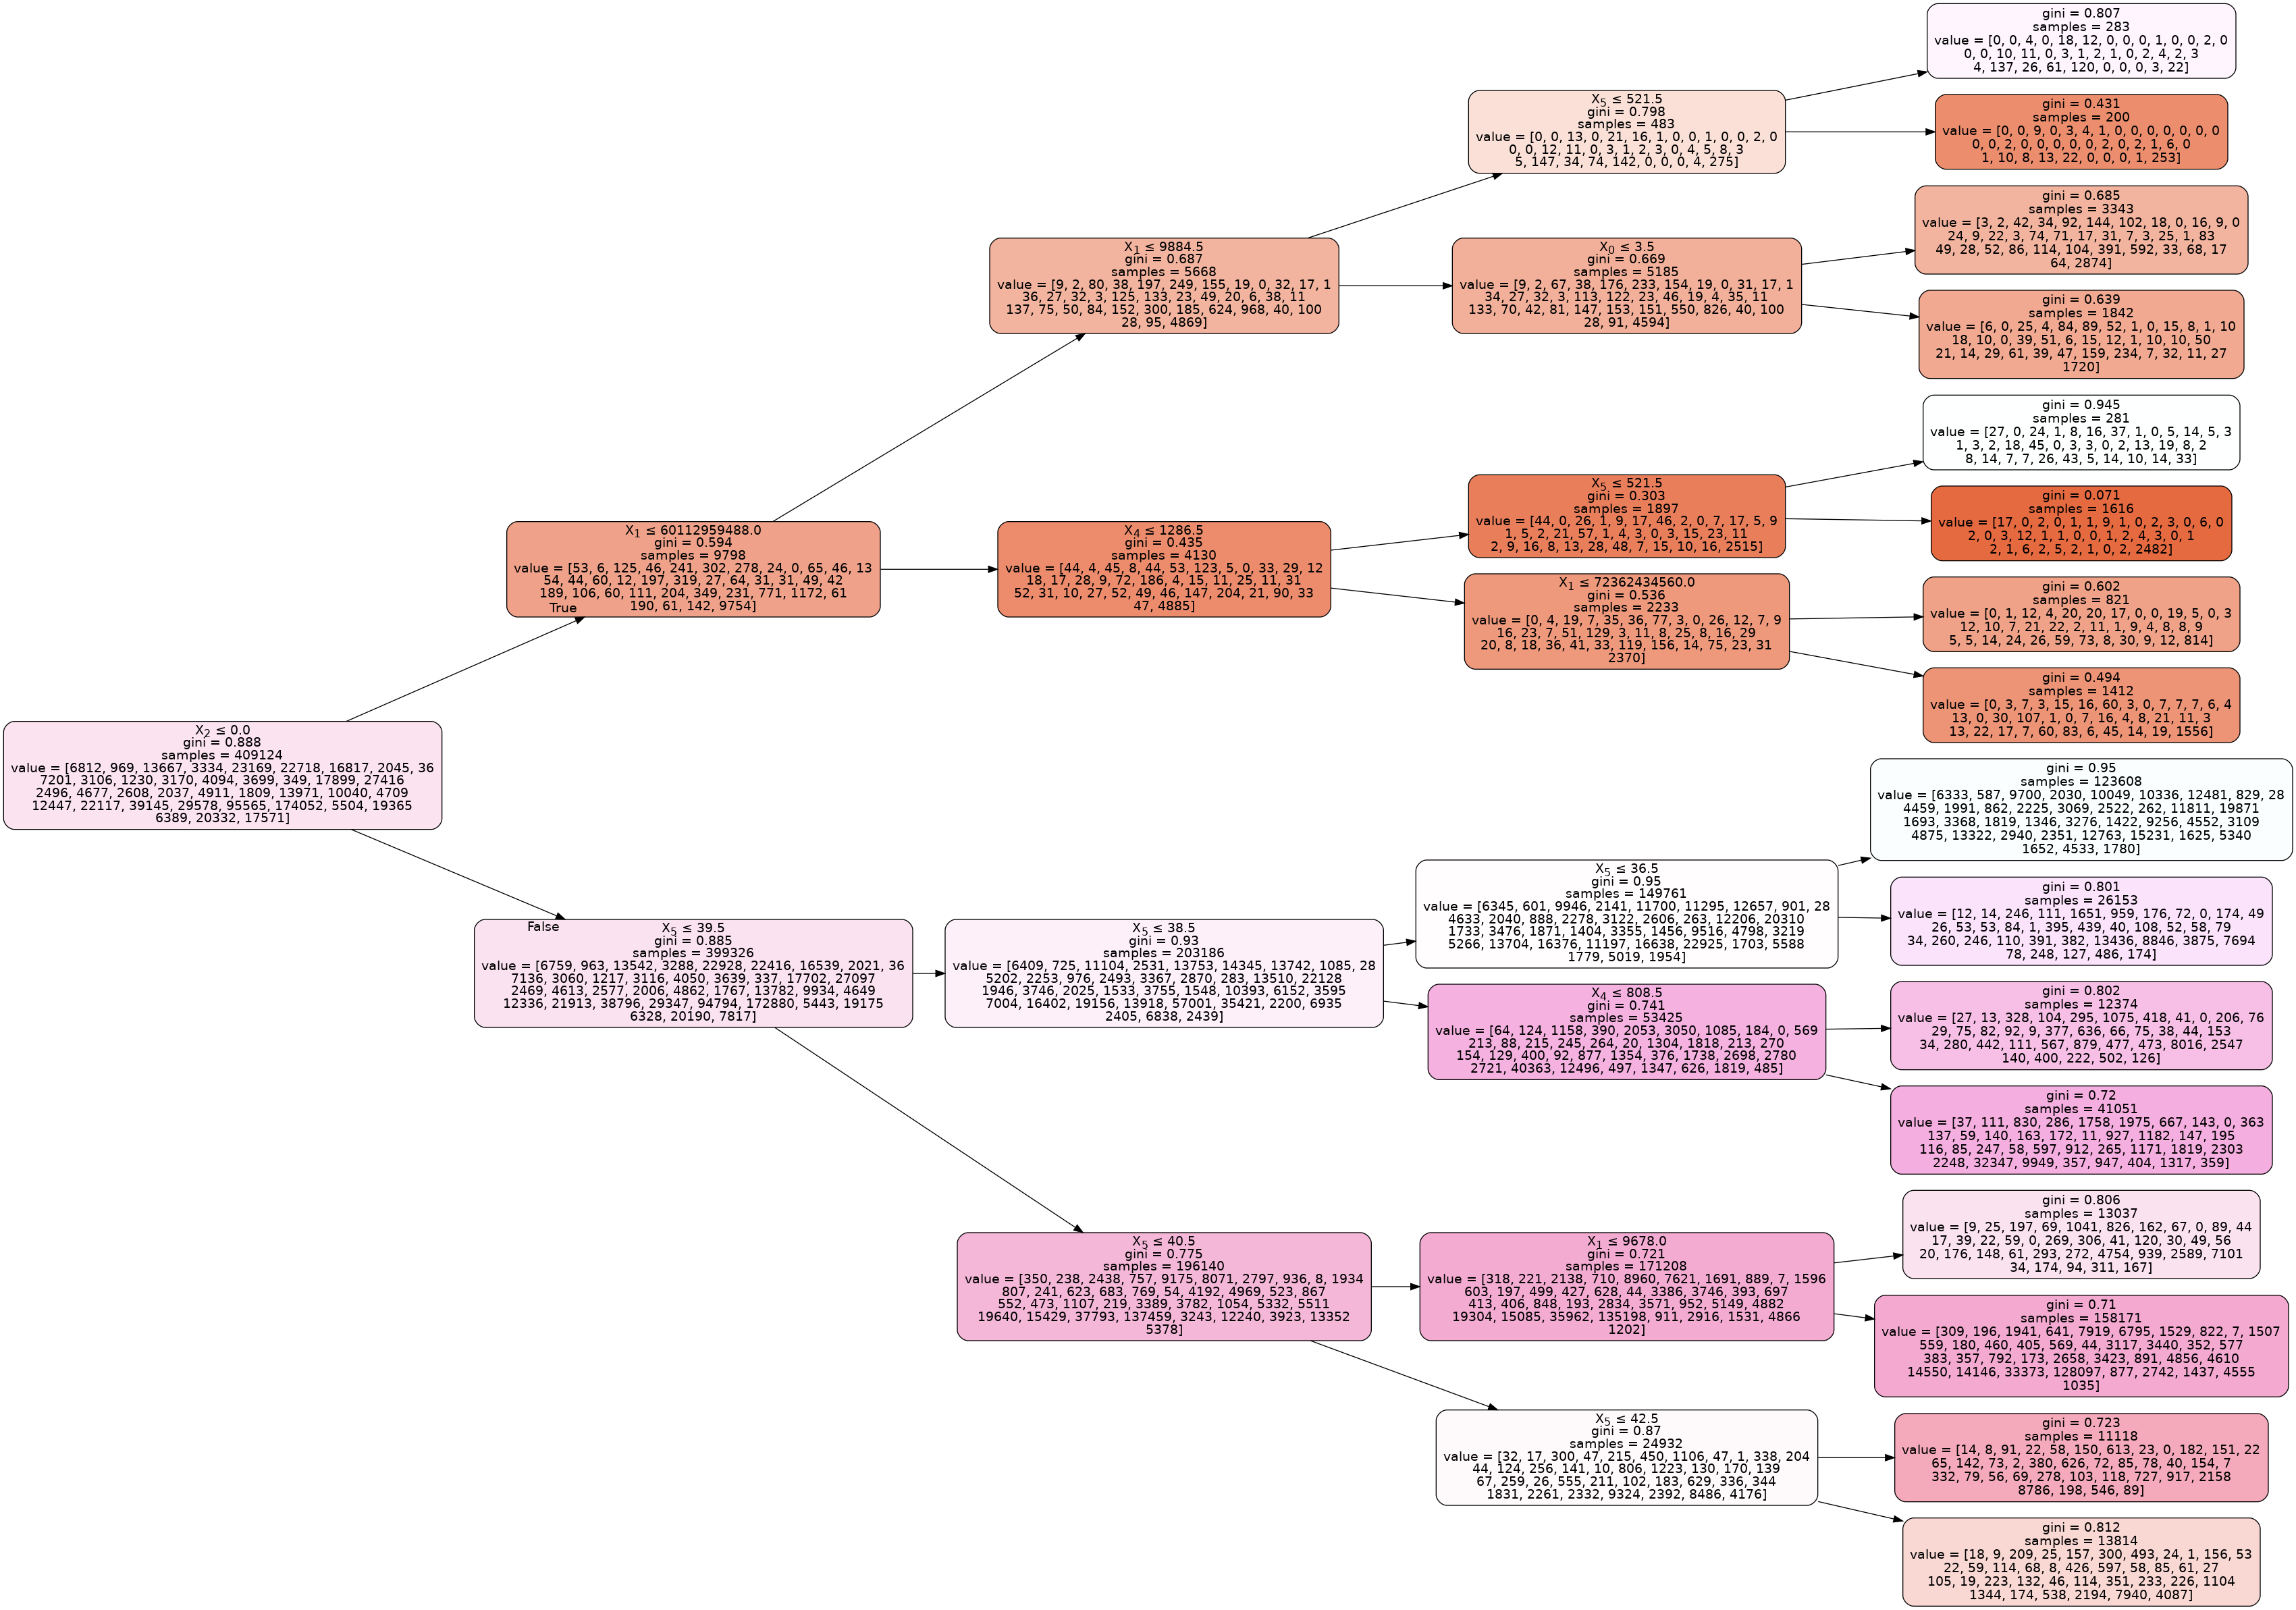

In [76]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz

import pydotplus

dot_data = StringIO()

export_graphviz(model.estimators_[0], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                rotate=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

**Question**: Look carefully at the nodes of the trees. What information is being displayed in each node?

In each node, you can see:
    
* The decision that was made: X_3 <= 32.5 means the value X_3 was checked against 32.5. All the rows (observed by the particular node) satisfying this condition went in one bucket and all the ones not satisfying went into another bucket.

* Number of samples in that bucket

* The number of samples with each class in that bucket. The purer the bucket, the smaller gini gets.

**Question**: During our linear regression exercise, we one-hot encoded the week days (or any categorical variable) because we didn't want to import an order on the variable values. Why is that not a concern with decision trees?

An example will suffice. Suppose, we have a feature with 3 distinct values: 'A', 'B', 'C'. We have 3! = 6 ways of mapping these values to 3 integers - 0, 1, 2.

Suppose, we pick an arbitrary mapping:

'A' -> 0

'B' -> 1

'C' -> 2

If the ordering of the target variable is: 'B' < 'A' < 'C' (all other features being constant), then linear regression would fail to predict the target accurately.

A tree on the other hand can still extract this structure at the cost of one extra decision:

First decision:

* FEATURE < 0.5 -> Isolate 'A' in bucket 1 and 'B', 'C' is bucket 2

* FEATURE < 1.5 on bucket 2 -> Isolate 'B' in bucket 3 and 'C' in bucket '4'

So while it would be nice if we had encoded the values as:

'B' -> 0

'A' -> 1

'C' -> 2

it is completely unnecessary to do so for a tree.

## Apply to featurized data from day 2 - linear regression

Recall one of the datasets from yesterday had one row per visit and one column per department. Let's use that data (without the weekday) to see how well do.

In [77]:
df_train = pd.read_feather(f'{DATA_PATH}/df_nonull_deprep_train_rnd.feather')
df_val = pd.read_feather(f'{DATA_PATH}/df_nonull_deprep_val.feather')
df_test = pd.read_feather(f'{DATA_PATH}/df_nonull_deprep_test.feather')

In [78]:
df_train.iloc[0]

TripType                                999
VisitNumber                               5
Weekday                              Friday
Upc                             6.81132e+10
ScanCount                                -1
DepartmentDescription    FINANCIAL SERVICES
FinelineNumber                         1000
Name: 0, dtype: object

Let's create the pivot tables

In [79]:
#note we have already replaced nulls and the department
df_train_f1 = pd.pivot_table(df_train, 
                             index='VisitNumber', 
                             columns='DepartmentDescription', 
                             values='ScanCount', 
                             aggfunc='sum').fillna(0)

df_val_f1 = pd.pivot_table(df_val, 
                           index='VisitNumber', 
                           columns='DepartmentDescription', 
                           values='ScanCount', 
                           aggfunc='sum').fillna(0)

df_test_f1 = pd.pivot_table(df_test,
                            index='VisitNumber',
                            columns='DepartmentDescription', 
                            values='ScanCount', 
                            aggfunc='sum').fillna(0)

#add trip type (target)
#add trip type
df_train_f1 = pd.concat([df_train[['VisitNumber', 'TripType']].drop_duplicates().set_index('VisitNumber'), df_train_f1], axis=1)
df_val_f1 = pd.concat([df_val[['VisitNumber', 'TripType']].drop_duplicates().set_index('VisitNumber'), df_val_f1], axis=1)
df_test_f1 = pd.concat([df_test[['VisitNumber', 'TripType']].drop_duplicates().set_index('VisitNumber'), df_test_f1], axis=1)

In [80]:
df_train_f1.head()

,TripType,-1,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,26,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
def train_model(model, df_train, df_val):
    model.fit(df_train.drop('TripType', axis=1), df_train['TripType'])
    
    train_class_pred = model.predict(df_train.drop('TripType', axis=1))
    val_class_pred = model.predict(df_val.drop('TripType', axis=1))

    train_acc = np.sum(train_class_pred==df_train['TripType'].tolist()) / df_train.shape[0]
    val_acc = np.sum(val_class_pred==df_val['TripType'].tolist()) / df_val.shape[0]

    print(f"Train Acc = {train_acc}")
    print(f"Val   Acc = {val_acc}")

    train_log_loss = log_loss(df_train['TripType'], model.predict_proba(df_train.drop('TripType', axis=1)), eps=1e-15)
    val_log_loss = log_loss(df_val['TripType'], model.predict_proba(df_val.drop('TripType', axis=1)), eps=1e-15, labels=model.classes_)

    print(f'Train loss = {train_log_loss}')
    print(f'Val   loss = {val_log_loss}')    
    
    return model, {'train': train_log_loss, 'val': val_log_loss}

In [82]:
model = RandomForestClassifier(n_estimators=10, max_depth=None, n_jobs=-1)

model, _ = train_model(model, df_train_f1, df_val_f1)

Train Acc = 0.89469420818145
Val   Acc = 0.6265286923800565
Train loss = 0.38210726990345734
Val   loss = 4.152398006182098


This is our first encounter with severe overfitting. Both the accuracy and loss are much better on the train set than the test set. In other words, the model is memorizing aspects of the training set that don't generalize to the validation set i.e. the model is fitting noise.

We can mitigate this by tuning the parameters in the model.

**Question**: Take a look at the scikit-learn page for random forests. What parameters do you think we can change to make the model less flexible (so it doesn't learn noise)?

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

In [83]:
model = RandomForestClassifier(n_estimators=100, max_depth=15, n_jobs=-1)

model, _ = train_model(model, df_train_f1, df_val_f1)

Train Acc = 0.62200969440416
Val   Acc = 0.5551374516567367
Train loss = 1.5053516702047964
Val   loss = 1.6940438458594231


As you can imagine, putting a limit on max depth truncates each tree at a fixed depth. While this does prevent overfitting, it is sometimes too aggressive.

In [84]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=150, n_jobs=-1)

model, _ = train_model(model, df_train_f1, df_val_f1)

Train Acc = 0.6811821424371889
Val   Acc = 0.6432528483328107
Train loss = 1.0140295242120663
Val   loss = 1.1852127014536091


Now that we have a decent model, let's spend time understanding what it does. First, let's look at feature importances.

In [85]:
import operator

feature_importances = sorted(list(zip(df_train_f1.drop('TripType', axis=1).columns, model.feature_importances_)), key = operator.itemgetter(1), reverse=True)

for f in feature_importances:
    print(f)

('FINANCIAL SERVICES', 0.06993282345979687)
('DSD GROCERY', 0.061859381428267336)
('GROCERY DRY GOODS', 0.05351969034693386)
('PERSONAL CARE', 0.04715705137055781)
('PHARMACY OTC', 0.03932865150256869)
('PRODUCE', 0.03893351191372411)
('MENS WEAR', 0.036324293154128544)
('PHARMACY RX', 0.035323653431827064)
('SERVICE DELI', 0.03472782144343603)
('DAIRY', 0.033852878571142976)
('INFANT CONSUMABLE HARDLINES', 0.02716915293905755)
('HOUSEHOLD CHEMICALS/SUPP', 0.026402211982441248)
('IMPULSE MERCHANDISE', 0.02317961515919993)
('LADIESWEAR', 0.022113205811390695)
('BEAUTY', 0.019418141886386214)
('FROZEN FOODS', 0.0193093157782905)
('HOUSEHOLD PAPER GOODS', 0.01707846127597108)
('AUTOMOTIVE', 0.016570420061378037)
('PETS AND SUPPLIES', 0.016520912246194112)
('CELEBRATION', 0.015653740836110427)
('COMM BREAD', 0.01494793650909355)
('MEAT - FRESH & FROZEN', 0.014582319837857622)
('SHOES', 0.014386108517188986)
('TOYS', 0.014299658054891997)
('OFFICE SUPPLIES', 0.013775176837215084)
('HOME MAN

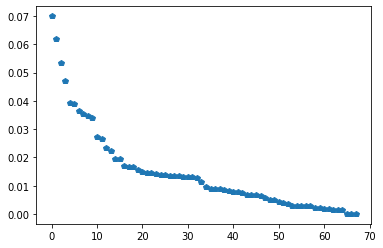

In [86]:
plt.plot([i[1] for i in feature_importances], 'p')

Feature importances are computed for each feature. Every time a decision is made using a feature (irrespective of the split), the change in the criterion (gini, entropy, MSE) between the parent node and the weighted average of the two children is added to the importance of the feature.

In other words, feature importance of a feature is the total improvement in the criterion when that feature is split upon. Once the importances are computed, they are normalized by dividing each importance by the sum of the importances across features.

**Question**[Optional]: Go to the random forest source code in sklearn and trace backwards to find the function definition where feature importances are computed.

https://github.com/scikit-learn/scikit-learn/blob/1495f6924/sklearn/ensemble/forest.py#L758

https://github.com/scikit-learn/scikit-learn/blob/1495f69242646d239d89a5713982946b8ffcf9d9/sklearn/tree/_tree.pyx

function: compute_feature_importances

The feature importances tell us that the first 4 variables alone have a lot of predictive power:

('FINANCIAL SERVICES', 0.0686859400714937)

('DSD GROCERY', 0.060437727913839334)

('GROCERY DRY GOODS', 0.051122381270331224)

('PERSONAL CARE', 0.04627539377686887)

while the last 3 variables seem to have almost no impact:

('SEASONAL', 8.317571292798545e-05)

('OTHER DEPARTMENTS', 6.962077428638214e-05)

('CONCEPT STORES', 1.7169241382028838e-05)

In a real-life situation, you would explore these columns more as well as talk to domain experts at your company (Walmart, in this case), to confirm that this is reasonable. You could also drop the columns that have almost no impact on the predictions.

**Question**: Sweep across min_samples_split with 5-10 values and plot both the train and validation log loss against min_samples_split.

In [87]:
train_loss_dict, val_loss_dict = {}, {}

for min_samples_split in [10, 50, 100, 150, 200, 300, 500]:
    model = RandomForestClassifier(n_estimators=100, min_samples_split=min_samples_split, n_jobs=-1)

    model, values_log_loss = train_model(model, df_train_f1, df_val_f1)
    
    train_loss_dict[min_samples_split] = values_log_loss['train']
    val_loss_dict[min_samples_split] = values_log_loss['val']

Train Acc = 0.8613517291838148
Val   Acc = 0.6614403679314309
Train loss = 0.5873931648101289
Val   loss = 1.241981102770304
Train Acc = 0.7430460288219077
Val   Acc = 0.6525556600815302
Train loss = 0.8351008242717575
Val   loss = 1.1673977227898356
Train Acc = 0.7005186898182626
Val   Acc = 0.6454478938016097
Train loss = 0.9500349550950153
Val   loss = 1.1680012677554563
Train Acc = 0.6805158154666249
Val   Acc = 0.6423121145604683
Train loss = 1.013881449310111
Val   loss = 1.188599064114967
Train Acc = 0.6672546022289291
Val   Acc = 0.6366677119264137
Train loss = 1.0599928341061684
Val   loss = 1.2037499850365547
Train Acc = 0.6454879211905041
Val   Acc = 0.6244381728859622
Train loss = 1.1398009258064274
Val   loss = 1.2438555733138819
Train Acc = 0.6187564509596415
Val   Acc = 0.6056234974391136
Train loss = 1.2387813691869527
Val   loss = 1.3075869222641354


**Question**: Plot both the train and val loss vs min_samples_split

Text(0, 0.5, 'log loss')

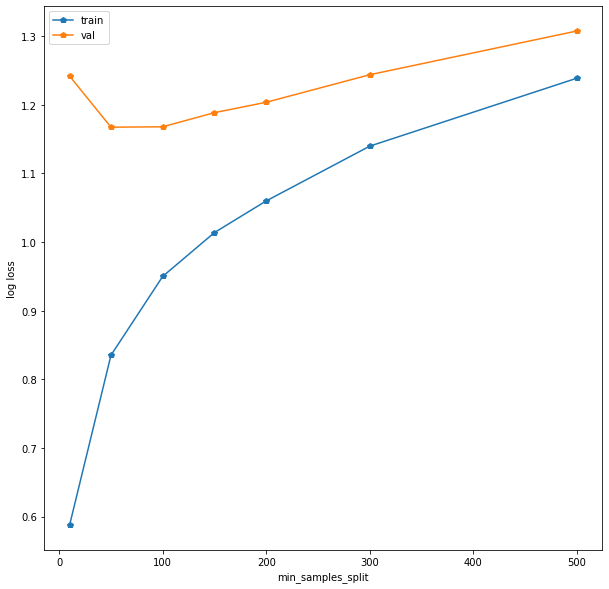

In [88]:
plt.figure(figsize=(10,10))

plt.plot(list(train_loss_dict.keys()), list(train_loss_dict.values()), 'p-', label='train')
plt.plot(list(val_loss_dict.keys()), list(val_loss_dict.values()), 'p-', label='val')

plt.legend()
plt.xlabel('min_samples_split')
plt.ylabel('log loss')

As one can see, for low min_samples_split, the severely overfit but increasing min_samples_split acts as a **regularizer** i.e. it constrains the model.

After around, say min_samples_split = 100-150, the model starts underfitting and both train and val performance get worse.

We see a minimum in our validation score at min_samples_split = 50 - 100 (one can do a more fine-grained scan). Let's pick 100.

In [89]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, n_jobs=-1)

model, _ = train_model(model, df_train_f1, df_val_f1)

Train Acc = 0.69976090620468
Val   Acc = 0.6456569457510192
Train loss = 0.9511169033558325
Val   loss = 1.18223812085597


### Bootstrapping

A random forest consists of an ensemble of n_estimator trees. Each tree needs some data to train on.

One possibility is to use the full dataset but this leads to overfitting as the number of trees go up. Instead, random forests using **bootstrapping**. Suppose there are N rows in the training data. Each tree will sample N rows **with replacement** from the training data. This sampled dataset is used to train the tree.

Sampling with replacement implies that there are certain rows from the training data that won't be seen by the tree and there are some that will occur multiple times.

There's another advantage to bootstrapping. We get an estimate for our validation score without creating a validation set!!

Since each tree potentially doesn't see some rows, as far as that tree is concerned, the missing rows are a validation set. So for each row in the full training data, we can identify all the trees that didn't see that particular row, use those trees to make a prediction and calculate an **out-of-sample** or **out-of-bag** loss.

Using oob_score = True in the random forest constructor does exactly that. This potentially lets us use the combined df_train and df_val for training.

In [90]:
model = RandomForestClassifier(n_estimators=150, min_samples_split=100, oob_score=True, n_jobs=-1)

model, _ = train_model(model, df_train_f1, df_val_f1)

Train Acc = 0.7003096460627916
Val   Acc = 0.6478519912198182
Train loss = 0.9485179387606976
Val   loss = 1.1651890705961887


Let's print out the oob score (= accuracy in this case)

In [91]:
print(model.oob_score_)

0.639700022210899


As you can see, this is remarkably close to the validation score we saw above. 

Another knob we can tune is max_features. 

Recall from the lecture that our goal is to make the errors from various trees as uncorrelated as possible. One way to do so is the make each tree train on a subset of the data (which is what bootstrapping does). Another is to make each tree work on a subset of columns.

The way random forests enforce this is on a per-node level. Each node in each tree randomly samples from the columns to pick a subset of features that it can split on. On that subset, it evaluate the criterion (gini, in this case), and picks the feature and the split that gives the best metric.

This subsetting of columns is controlled by "max_features". max_features = "auto" picks sqrt(number of columns) features randomly and searches (greedily) for the best splits on them.

**Question**: Do a sweep across max_features from 1 to number of columns and plot both the training and validation losses as a function of max_features.

In [92]:
train_loss_dict, val_loss_dict = {}, {}

STEPSIZE = #this is meant to break this cell since this is a computationally heavy loop

for max_features in np.arange(1, df_train_f1.shape[1]-1, STEPSIZE):
    model = RandomForestClassifier(n_estimators=100, min_samples_split=100, max_features=max_features, n_jobs=-1)

    model, values_log_loss = train_model(model, df_train_f1, df_val_f1)
    
    train_loss_dict[max_features] = values_log_loss['train']
    val_loss_dict[max_features] = values_log_loss['val']

Train Acc = 0.7256562014136584
Val   Acc = 0.6617539458555451
Train loss = 0.9796013716323067
Val   loss = 1.1553728380329584
Train Acc = 0.724401938880832
Val   Acc = 0.6613358419567262
Train loss = 0.9676875242443173
Val   loss = 1.1500905658313112
Train Acc = 0.7193064973412248
Val   Acc = 0.6611267900073168
Train loss = 0.9596590397047209
Val   loss = 1.1485010972213496
Train Acc = 0.715426122630293
Val   Acc = 0.6574683808926518
Train loss = 0.9546558907474041
Val   loss = 1.1486544575491258
Train Acc = 0.7110753994695515
Val   Acc = 0.6552733354238528
Train loss = 0.9521307311562388
Val   loss = 1.1511822447619184
Train Acc = 0.7068161329518284
Val   Acc = 0.6528692380056444
Train loss = 0.9513490417045163
Val   loss = 1.1523030378287953
Train Acc = 0.7034844980990084
Val   Acc = 0.6495244068150936
Train loss = 0.9498828278896938
Val   loss = 1.1600132528489768
Train Acc = 0.699303622989587
Val   Acc = 0.6471203093968851
Train loss = 0.9497642735416282
Val   loss = 1.182752600396

Train loss = 0.9844954085536497
Val   loss = 1.5039797677586475
Train Acc = 0.6648897947451626
Val   Acc = 0.6179575624542699
Train loss = 0.9861779765396563
Val   loss = 1.5312846797197508


Text(0, 0.5, 'log loss')

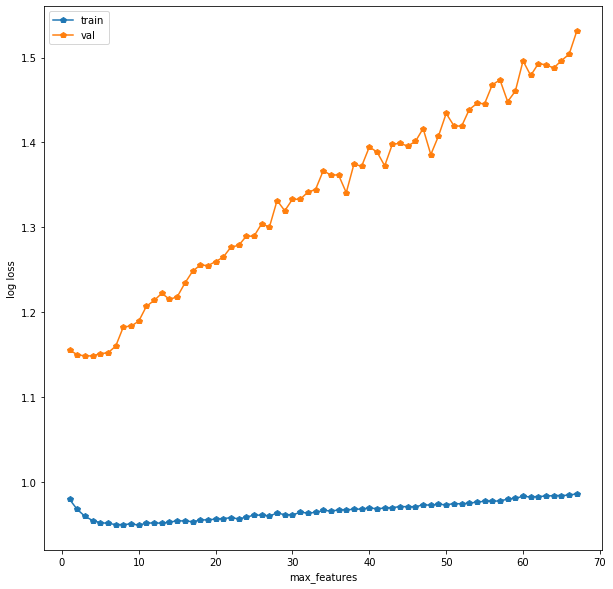

In [145]:
plt.figure(figsize=(10,10))

plt.plot(list(train_loss_dict.keys()), list(train_loss_dict.values()), 'p-', label='train')
plt.plot(list(val_loss_dict.keys()), list(val_loss_dict.values()), 'p-', label='val')

plt.legend()
plt.xlabel('max_features')
plt.ylabel('log loss')

As one can see, as each node considers more and more, there's some initial improvement but then with too many features, the validation loss increases pretty rapidly.

It seems the optimal max_features is at 3 ~ log_2(number of features = 68) / 2.

In [94]:
np.log2(df_train_f1.shape[1]-1)

6.087462841250339

Another parameter we can change is the criterion.

**Question**: Look at the available criteria in the documentation. What else could we use for a classification problem?

We'll use entropy.

In [95]:
model = RandomForestClassifier(criterion = 'gini', 
                               n_estimators=150, 
                               min_samples_split=100, 
                               max_features=3, 
                               oob_score=True, 
                               n_jobs=-1)

model, _ = train_model(model, df_train_f1, df_val_f1)

print(model.oob_score_)

Train Acc = 0.7206260860476359
Val   Acc = 0.6614403679314309
Train loss = 0.9578300591138791
Val   loss = 1.1420072138822153
0.6485843818184194


In [96]:
model = RandomForestClassifier(criterion = 'entropy', 
                               n_estimators=150, 
                               min_samples_split=100, 
                               max_features=3, 
                               oob_score=True, 
                               n_jobs=-1)

model, _ = train_model(model, df_train_f1, df_val_f1)

print(model.oob_score_)

Train Acc = 0.6976443381805354
Val   Acc = 0.6495244068150936
Train loss = 1.01096679221091
Val   loss = 1.1689622007895737
0.6366296920524177


Not much difference here.

## What next?

At this stage, the majority of work is that of feature engineering. This involves thinking about the problem and using all the data you can to construct as many features as you can. The trained model is then inspected to understand the relationship between the features and the target.

### Normalize the distributions

In [97]:
df_train_f1_features = df_train_f1.drop('TripType', axis=1)
df_train_f1_target = df_train_f1['TripType']

df_val_f1_features = df_val_f1.drop('TripType', axis=1)
df_val_f1_target = df_val_f1['TripType']

df_test_f1_features = df_test_f1.drop('TripType', axis=1)
df_test_f1_target = df_test_f1['TripType']

In [98]:
train_counts = df_train_f1_features.sum(axis=1)
val_counts = df_val_f1_features.sum(axis=1)
test_counts = df_test_f1_features.sum(axis=1)

**Question**: Divide the counts for each trip by the total number of items bought. How would you deal with negative (returns) counts?

In [99]:
df_train_f1_scaled = df_train_f1_features.apply(lambda x: x.abs() / x.abs().sum(), axis=1)
df_val_f1_scaled = df_val_f1_features.apply(lambda x: x.abs() / x.abs().sum(), axis=1)
df_test_f1_scaled = df_test_f1_features.apply(lambda x: x.abs() / x.abs().sum(), axis=1)

**Question**: Confirm that the sum of absolute values along each row gives 1.

In [100]:
np.unique(df_train_f1_scaled.abs().sum(axis=1), return_counts=True)

(array([0., 1., 1., 1., 1.]), array([ 1162,   451,  4432, 70256,   238]))

**Question**: What are all the rows that add up to 0?

In [101]:
df_train_f1_scaled[df_train_f1_scaled.abs().sum(axis=1)==0].head()

,-1,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,
133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Question**: You should find that these rows have nulls. Why is that?

The only possibility is that when we divide by x.abs().sum(), we are dividing by 0? Since we are taking absolute values, this is only possible if every count is 0 (then why is the trip even in our dataset)?

**Question**: Confirm this guess.

In [102]:
zero_sums = df_train_f1_features[df_train_f1_features.abs().sum(axis=1)==0]
print(zero_sums.shape)

(1162, 68)


In [103]:
df_train[df_train['VisitNumber'].isin(zero_sums.index)]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
245,999,133,Friday,9.933894e+09,-1,LADIESWEAR,1180.0
246,999,133,Friday,9.933894e+09,1,LADIESWEAR,1180.0
586,999,333,Friday,6.565145e+10,1,JEWELRY AND SUNGLASSES,6812.0
587,999,333,Friday,6.565145e+10,-1,JEWELRY AND SUNGLASSES,6812.0
1100,999,581,Friday,8.085947e+10,1,LADIESWEAR,2064.0
...,...,...,...,...,...,...,...
516076,999,190392,Sunday,3.338320e+09,-1,PRODUCE,3602.0
516077,999,190392,Sunday,3.338320e+09,1,PRODUCE,3602.0
516078,999,190392,Sunday,4.011000e+03,-1,PRODUCE,5501.0
516157,999,190435,Sunday,1.292611e+09,1,SHOES,3342.0


**Question**: What is your conclusion about these zeros?

These zeros occur when N items were bought and N items were returns in the same trip with the SAME department. That leads to a cancellation when we add up ScanCount in our pivot table. So we have trips where all the entries are 0s! Admittedly, this doesn't happen too often (1162 visits / 76539 visits ~ 1.15%) but still it's worrying.

So how should we deal with this?

**Question**: Come up with some ideas to work with this.

**Option 1** One possibility is to modify our pivot table where we add up the absolute values so even returns are counted as items purchased. This is not quite right but maybe we can add an additional column that is Boolean and indicates whether there was a return in the trip or not.

**Option  2**: Another possibility is to drop all returns and just keep the Boolean for a trip. This doesn't distinguish between 1 returned item and 10 returned items. To go forward with this, we should look at the number of return items in each trip.

In [104]:
df_train[df_train['ScanCount'] < 0].groupby('VisitNumber').sum()['ScanCount'].value_counts()

-1     6556
-2     1368
-3      446
-4      234
-5      107
-6       63
-7       33
-8       24
-9       12
-10      10
-11       6
-15       6
-14       3
-23       2
-13       2
-26       2
-12       2
-16       1
-17       1
-30       1
-21       1
-52       1
-37       1
Name: ScanCount, dtype: int64

So most trips do have 1 or 2 returns and maybe this strategy would work.

**Option 3**: Yet another option is to only count the bought items in the pivot table and keep a separate item with the number of items returned. Here we lose information about which department the item was bought in but maybe that's enough.

**Option 4**: Lastly, we could double the number of columns/features with one column for items bought in each department and one column for items returned in each department. The columns with returns will be very sparse though.

**Question**: Implement option 3

In [105]:
#note we have already replaced nulls and the department
df_train_f1 = pd.pivot_table(df_train[df_train['ScanCount']>0], 
                             index='VisitNumber', 
                             columns='DepartmentDescription', 
                             values='ScanCount', 
                             aggfunc='sum').fillna(0)

df_val_f1 = pd.pivot_table(df_val[df_val['ScanCount']>0], 
                           index='VisitNumber', 
                           columns='DepartmentDescription', 
                           values='ScanCount', 
                           aggfunc='sum').fillna(0)

df_test_f1 = pd.pivot_table(df_test[df_test['ScanCount']>0],
                            index='VisitNumber',
                            columns='DepartmentDescription', 
                            values='ScanCount', 
                            aggfunc='sum').fillna(0)


In [106]:
#normalize these values
df_train_f1_scaled = df_train_f1.apply(lambda x: x / x.sum(), axis=1)
df_val_f1_scaled = df_val_f1.apply(lambda x: x / x.sum(), axis=1)
df_test_f1_scaled = df_test_f1.apply(lambda x: x / x.sum(), axis=1)

**Question**: Ensure each row adds up to 1.

In [107]:
print(df_train_f1_scaled.abs().sum(axis=1).value_counts())

1.0    68106
1.0     4434
1.0      439
1.0      240
dtype: int64


In [108]:
print(df_val_f1_scaled.abs().sum(axis=1).value_counts())

1.0    8568
1.0     529
1.0      50
1.0      28
dtype: int64


In [109]:
print(df_test_f1_scaled.abs().sum(axis=1).value_counts())

1.0    8518
1.0     553
1.0      58
1.0      24
dtype: int64


**Question**: Insert a count with total counts of objects **bought**

In [110]:
df_train_f1_scaled['TotalBought'] = df_train_f1.sum(axis=1)
df_val_f1_scaled['TotalBought'] = df_val_f1.sum(axis=1)
df_test_f1_scaled['TotalBought'] = df_test_f1.sum(axis=1)

In [111]:
df_train_f1_scaled.head()

DepartmentDescription,-1,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,...,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,TotalBought
VisitNumber,,,,,,,,,,,,,,,,,,,,,
8,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,30.0
9,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3.0
10,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3.0
11,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,4.0
12,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285714,...,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,7.0


In [112]:
#Ensure total bought is > 0
assert((df_train_f1_scaled['TotalBought']==0).sum()==0)
assert((df_val_f1_scaled['TotalBought']==0).sum()==0)
assert((df_test_f1_scaled['TotalBought']==0).sum()==0)

**Question**: Add a column with total number of items returned (as a positive integer).

In [113]:
df_train[df_train['ScanCount']<0].groupby('VisitNumber').sum().abs()['ScanCount'].reset_index()

,VisitNumber,ScanCount
0,5,1.0
1,8,2.0
2,132,2.0
3,133,1.0
4,182,1.0
...,...,...
8877,191089,1.0
8878,191099,1.0
8879,191170,1.0
8880,191298,1.0


In [114]:
df_train_f1_scaled = pd.merge(df_train_f1_scaled.reset_index(), df_train[df_train['ScanCount']<0].groupby('VisitNumber').sum().abs()['ScanCount'].reset_index(),
                              on='VisitNumber', how='outer').sort_values('VisitNumber').set_index('VisitNumber')

df_val_f1_scaled = pd.merge(df_val_f1_scaled.reset_index(), df_val[df_val['ScanCount']<0].groupby('VisitNumber').sum().abs()['ScanCount'].reset_index(),
                            on='VisitNumber', how='outer').sort_values('VisitNumber').set_index('VisitNumber')

df_test_f1_scaled = pd.merge(df_test_f1_scaled.reset_index(), df_test[df_test['ScanCount']<0].groupby('VisitNumber').sum().abs()['ScanCount'].reset_index(),
                             on='VisitNumber', how='outer').sort_values('VisitNumber').set_index('VisitNumber')


In [115]:
df_train_f1_scaled.rename({'ScanCount': 'TotalReturned'}, inplace=True, axis=1)
df_val_f1_scaled.rename({'ScanCount': 'TotalReturned'}, inplace=True, axis=1)
df_test_f1_scaled.rename({'ScanCount': 'TotalReturned'}, inplace=True, axis=1)

In [116]:
df_train_f1_scaled.head()

,-1,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,...,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,TotalBought,TotalReturned
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
8,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,2.0
9,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,NaN
10,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,NaN
11,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,NaN


In [117]:
df_train_f1_scaled.head()

,-1,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,...,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,TotalBought,TotalReturned
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
8,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,2.0
9,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,NaN
10,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,NaN
11,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,NaN


**Question**: Is there any problem with this procedure?

We almost certainly have nulls for visits where there were no returns. We also have nulls for trips that only had returns and nothing bought.

**Question**: Check and fix this.

In [118]:
df_train_f1_scaled.fillna(0, inplace=True)
df_val_f1_scaled.fillna(0, inplace=True)
df_test_f1_scaled.fillna(0, inplace=True)

**Question**: We also need the trip type (target) as a column. Add that in.

In [119]:
df_train_f1_scaled = pd.concat([df_train[['VisitNumber', 'TripType']].drop_duplicates().set_index('VisitNumber'), df_train_f1_scaled], axis=1)
df_val_f1_scaled = pd.concat([df_val[['VisitNumber', 'TripType']].drop_duplicates().set_index('VisitNumber'), df_val_f1_scaled], axis=1)
df_test_f1_scaled = pd.concat([df_test[['VisitNumber', 'TripType']].drop_duplicates().set_index('VisitNumber'), df_test_f1_scaled], axis=1)

In [120]:
df_train_f1_scaled.head()

,TripType,-1,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,...,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,TotalBought,TotalReturned
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,999,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,26,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,2.0
9,8,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
10,8,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
11,35,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0


**Question**: Are there any more nulls?

In [121]:
assert(df_train_f1_scaled.isnull().sum().sum()==0)
assert(df_val_f1_scaled.isnull().sum().sum()==0)
assert(df_test_f1_scaled.isnull().sum().sum()==0)

In [122]:
df_train_f1_scaled.columns

Index(['TripType', '-1', '1-HR PHOTO', 'ACCESSORIES', 'AUTOMOTIVE', 'BAKERY',
       'BATH AND SHOWER', 'BEAUTY', 'BEDDING', 'BOOKS AND MAGAZINES',
       'BOYS WEAR', 'BRAS & SHAPEWEAR', 'CAMERAS AND SUPPLIES',
       'CANDY, TOBACCO, COOKIES', 'CELEBRATION', 'COMM BREAD',
       'CONCEPT STORES', 'COOK AND DINE', 'DAIRY', 'DSD GROCERY',
       'ELECTRONICS', 'FABRICS AND CRAFTS', 'FINANCIAL SERVICES',
       'FROZEN FOODS', 'FURNITURE', 'GIRLS WEAR, 4-6X  AND 7-14',
       'GROCERY DRY GOODS', 'HARDWARE', 'HOME DECOR', 'HOME MANAGEMENT',
       'HORTICULTURE AND ACCESS', 'HOUSEHOLD CHEMICALS/SUPP',
       'HOUSEHOLD PAPER GOODS', 'IMPULSE MERCHANDISE', 'INFANT APPAREL',
       'INFANT CONSUMABLE HARDLINES', 'JEWELRY AND SUNGLASSES', 'LADIES SOCKS',
       'LADIESWEAR', 'LARGE HOUSEHOLD GOODS', 'LAWN AND GARDEN',
       'LIQUOR,WINE,BEER', 'MEAT - FRESH & FROZEN', 'MEDIA AND GAMING',
       'MENS WEAR', 'MENSWEAR', 'OFFICE SUPPLIES', 'OPTICAL - FRAMES',
       'OPTICAL - LENSES', 'OTH

**Question**: Train a new random forest model on this normalized data with counts of total items bought and total items returned.

In [123]:
model = RandomForestClassifier(criterion = 'gini', 
                               n_estimators=150, 
                               min_samples_split=100, 
                               max_features='auto', 
                               oob_score=True, 
                               n_jobs=-1)

model, _ = train_model(model, df_train_f1_scaled, df_val_f1_scaled)

print(model.oob_score_)

Train Acc = 0.7202471942408445
Val   Acc = 0.6835998745688303
Train loss = 0.8465840412383053
Val   loss = 1.0160118481043627
0.6810253596205856


Excellent! We have a much lower validation loss from ~1.17 with the old features to ~1.01. That's a big improvement. Let's now also add in weekday for each trip.

**Question**: List the feature importances for this model. Is this consistent with what we found earlier?

In [124]:
sorted(zip(df_train_f1_scaled.drop('TripType', axis=1).columns, model.feature_importances_), key=operator.itemgetter(1), reverse=True)

[('TotalBought', 0.20016482187512882),
 ('TotalReturned', 0.06591528927086124),
 ('FINANCIAL SERVICES', 0.058411498883466896),
 ('DSD GROCERY', 0.05348362452257909),
 ('PERSONAL CARE', 0.03897191557922922),
 ('PHARMACY OTC', 0.03820365348591199),
 ('SERVICE DELI', 0.035248762253054504),
 ('PRODUCE', 0.03500768552794944),
 ('DAIRY', 0.03237025632988053),
 ('PHARMACY RX', 0.030567671318039676),
 ('GROCERY DRY GOODS', 0.0301788685755558),
 ('MENS WEAR', 0.024009470248350376),
 ('HOUSEHOLD CHEMICALS/SUPP', 0.0229520516160756),
 ('INFANT CONSUMABLE HARDLINES', 0.021310588407523864),
 ('BEAUTY', 0.016788396463318905),
 ('IMPULSE MERCHANDISE', 0.015992648118721062),
 ('MEAT - FRESH & FROZEN', 0.015140385168364025),
 ('FROZEN FOODS', 0.014484951934968609),
 ('HOUSEHOLD PAPER GOODS', 0.014378351486330224),
 ('LADIESWEAR', 0.0126976496041823),
 ('COMM BREAD', 0.012371536549889933),
 ('PETS AND SUPPLIES', 0.012249870931130988),
 ('LIQUOR,WINE,BEER', 0.011980135438541406),
 ('CANDY, TOBACCO, COOKI

The biggest impact is the total number of items bought! The next biggest impact is the total number of items returned.

**Question**: Add weekday as a feature. Encode it as an integer either using pandas or sklearn's label encoder.

In [125]:
df_train_f1_scaled['Weekday'] = df_train[['VisitNumber', 'Weekday']].drop_duplicates().set_index('VisitNumber')

In [126]:
df_train_f1_scaled.head()

,TripType,-1,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,...,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,TotalBought,TotalReturned,Weekday
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,999,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Friday
8,26,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,2.0,Friday
9,8,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,Friday
10,8,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,Friday
11,35,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,Friday


In [127]:
df_val_f1_scaled['Weekday'] = df_val[['VisitNumber', 'Weekday']].drop_duplicates().set_index('VisitNumber')

In [128]:
df_test_f1_scaled['Weekday'] = df_test[['VisitNumber', 'Weekday']].drop_duplicates().set_index('VisitNumber')

In [129]:
from sklearn.preprocessing import LabelEncoder

In [130]:
weekday_encoder = LabelEncoder().fit(df_train_f1_scaled['Weekday'])

In [131]:
df_train_f1_scaled['Weekday'] = weekday_encoder.transform(df_train_f1_scaled['Weekday'])
df_val_f1_scaled['Weekday'] = weekday_encoder.transform(df_val_f1_scaled['Weekday'])
df_test_f1_scaled['Weekday'] = weekday_encoder.transform(df_test_f1_scaled['Weekday'])

In [132]:
df_train_f1_scaled['Weekday'].value_counts()

3    13794
2    13542
0    12135
1     9605
6     9274
5     9225
4     8964
Name: Weekday, dtype: int64

In [133]:
df_val_f1_scaled['Weekday'].value_counts()

3    1663
2    1627
0    1566
6    1209
1    1208
4    1158
5    1136
Name: Weekday, dtype: int64

In [134]:
df_test_f1_scaled['Weekday'].value_counts()

2    1735
3    1667
0    1533
1    1214
5    1169
6    1129
4    1121
Name: Weekday, dtype: int64

In [135]:
model = RandomForestClassifier(criterion = 'gini', 
                               n_estimators=150, 
                               min_samples_split=100, 
                               max_features='auto', 
                               oob_score=True, 
                               n_jobs=-1)

model, _ = train_model(model, df_train_f1_scaled, df_val_f1_scaled)

print(model.oob_score_)

Train Acc = 0.7194240844536772
Val   Acc = 0.6805686213023936
Train loss = 0.8540134818364974
Val   loss = 1.0245487632926449
0.680032401782098


We actually seem to have gotten a little worse after adding in weekday as a column.

**Question**: Print the feature importances.

In [136]:
sorted(zip(df_train_f1_scaled.drop('TripType', axis=1).columns, model.feature_importances_), key=operator.itemgetter(1), reverse=True)

[('TotalBought', 0.18776273934446674),
 ('TotalReturned', 0.07138838811458732),
 ('FINANCIAL SERVICES', 0.05847071575847857),
 ('DSD GROCERY', 0.05284966237457417),
 ('PERSONAL CARE', 0.03902771379445158),
 ('PHARMACY OTC', 0.03866111706117702),
 ('SERVICE DELI', 0.03564722180135505),
 ('PRODUCE', 0.0347494173778823),
 ('DAIRY', 0.03339455828303909),
 ('GROCERY DRY GOODS', 0.032629310695024574),
 ('PHARMACY RX', 0.030929550300882867),
 ('HOUSEHOLD CHEMICALS/SUPP', 0.02391124321708959),
 ('MENS WEAR', 0.023780726747170265),
 ('INFANT CONSUMABLE HARDLINES', 0.0211513673687785),
 ('BEAUTY', 0.016674978802316397),
 ('IMPULSE MERCHANDISE', 0.015234574331899398),
 ('MEAT - FRESH & FROZEN', 0.015105772569360368),
 ('FROZEN FOODS', 0.013555672798413949),
 ('HOUSEHOLD PAPER GOODS', 0.013233220585663426),
 ('LADIESWEAR', 0.01301649705608114),
 ('COMM BREAD', 0.012064801537635712),
 ('PETS AND SUPPLIES', 0.011967770752718484),
 ('LIQUOR,WINE,BEER', 0.011900873573263299),
 ('AUTOMOTIVE', 0.0109955

Weekday is actually not an impactful feature at all. It has a tiny impact on the classification of a trip. One way to measure the impact of weekday according to this model is to make a partial dependence plot.

The idea is that we can't really compare the predictions for say, Monday vs Tuesday since the other features vary when we filter on certain weekdays. So, what if we replace all weekdays by Monday and make the prediction and then repeat for all other days. We won't make this plot here (maybe in a second iteration of this class but we can't possibly cover everything).

**Question**: Try one-hot encoding the values for weekday. What effect does this have on a tree?

One-hot encoding makes it easy to pick a particular weekday with just one decision.

In [137]:
df_train_f1_scaled_onehot = pd.concat([df_train_f1_scaled, pd.get_dummies(df_train_f1_scaled['Weekday'], prefix='Weekday')], axis=1).drop('Weekday', axis=1)

In [138]:
df_train_f1_scaled_onehot.head()

,TripType,-1,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,...,WIRELESS,TotalBought,TotalReturned,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,999,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1,0,0,0,0,0,0
8,26,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,30.0,2.0,1,0,0,0,0,0,0
9,8,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,1,0,0,0,0,0,0
10,8,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,1,0,0,0,0,0,0
11,35,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,1,0,0,0,0,0,0


In [139]:
df_val_f1_scaled_onehot = pd.concat([df_val_f1_scaled, pd.get_dummies(df_val_f1_scaled['Weekday'], prefix='Weekday')], axis=1).drop('Weekday', axis=1)

In [140]:
df_test_f1_scaled_onehot = pd.concat([df_test_f1_scaled, pd.get_dummies(df_test_f1_scaled['Weekday'], prefix='Weekday')], axis=1).drop('Weekday', axis=1)

In [141]:
model = RandomForestClassifier(criterion = 'gini', 
                               n_estimators=150, 
                               min_samples_split=100, 
                               max_features='auto', 
                               oob_score=True, 
                               n_jobs=-1)

model, _ = train_model(model, df_train_f1_scaled_onehot, df_val_f1_scaled_onehot)

print(model.oob_score_)

Train Acc = 0.7189668012385843
Val   Acc = 0.6802550433782795
Train loss = 0.8602650010004443
Val   loss = 1.0244714511009956
0.6797972275571931


**Question**: Take a look at feature importances again. We now have importances for each day. Are these significantly different from what we saw earlier?

In [142]:
sorted(zip(df_train_f1_scaled_onehot.drop('TripType', axis=1).columns, model.feature_importances_), key=operator.itemgetter(1), reverse=True)

[('TotalBought', 0.18396799945271378),
 ('TotalReturned', 0.0730398615302425),
 ('FINANCIAL SERVICES', 0.059056443187431557),
 ('DSD GROCERY', 0.053481687921422834),
 ('PERSONAL CARE', 0.03949289334161555),
 ('PHARMACY OTC', 0.03794153755018768),
 ('SERVICE DELI', 0.03591443005611283),
 ('PRODUCE', 0.035017541200636486),
 ('GROCERY DRY GOODS', 0.03279240529941971),
 ('DAIRY', 0.03138574211524817),
 ('PHARMACY RX', 0.03129294770455599),
 ('MENS WEAR', 0.02408107660005898),
 ('HOUSEHOLD CHEMICALS/SUPP', 0.02228259904464434),
 ('INFANT CONSUMABLE HARDLINES', 0.021228867874603725),
 ('BEAUTY', 0.016714770635309052),
 ('MEAT - FRESH & FROZEN', 0.015266135179559442),
 ('IMPULSE MERCHANDISE', 0.015018157832943687),
 ('FROZEN FOODS', 0.013979054746606084),
 ('HOUSEHOLD PAPER GOODS', 0.01353828685305488),
 ('LADIESWEAR', 0.013055839593778143),
 ('COMM BREAD', 0.012251943609381226),
 ('PETS AND SUPPLIES', 0.011885572189784435),
 ('LIQUOR,WINE,BEER', 0.011833511896599246),
 ('AUTOMOTIVE', 0.01110

The highest weekday importance for Weekday_1 (Monday) and even that is tiny. The other weekday importances are even smaller - consistent with our earlier conclusion.

### Next Steps

At this stage, there are several direction to go in. On the feature engineering side:

* Compare the values of department descriptions and combine similar ones into one category.

* Use FinelineNumber and Upc counts as features. This will cause the dataframe to explode given the number of distinct values in each of the column and maybe doing something similar to the combination for departments, will be helpful. This is easier said than done though because unlike departments, we have no intuitive understanding of finelinenumbers and upc codes unless we read more about them and see what the structure of the codes mean.

* Replacing categorical features not by arbitrary integers but by more meaningful encodings (target class encodings, for example).

* Use more powerful modeling techniques. Maybe boosted decision trees (see xgboost, lightgbm) or neural networks (the next two days).

The last thing I want to show here is a neat library called treeinterpreter.

In [143]:
from treeinterpreter import treeinterpreter as ti

In [160]:
prediction, bias, contributions = ti.predict(model.estimators_[0], df_val_f1_scaled_onehot.drop('TripType', axis=1).head(1))

In [161]:
print(prediction.shape)
print(prediction)
print(np.sum(prediction, axis=1))

(1, 38)
[[0.    0.    0.    0.    0.    0.008 0.664 0.    0.    0.    0.    0.
  0.    0.    0.024 0.    0.008 0.016 0.    0.    0.    0.    0.248 0.008
  0.    0.    0.    0.    0.008 0.    0.    0.    0.    0.    0.    0.
  0.    0.016]]
[1.]


In [162]:
bias

array([[3.82158115e-02, 3.20098251e-03, 4.68388665e-02, 1.29476476e-02,
        6.14066032e-02, 1.24498622e-01, 1.00118894e-01, 2.66530788e-03,
        1.30652347e-05, 1.11185147e-02, 5.94468180e-03, 3.85424424e-03,
        6.95070487e-03, 6.19292126e-03, 9.70746939e-03, 1.59395864e-03,
        2.60651433e-02, 3.89997256e-02, 5.51352905e-03, 8.63612015e-03,
        5.47433335e-03, 4.79494114e-03, 1.12491671e-02, 5.99694274e-03,
        2.12310064e-02, 1.46330629e-02, 7.38185762e-03, 2.02772443e-02,
        3.11736500e-02, 2.98148656e-02, 3.02852141e-02, 1.02196266e-01,
        6.42678896e-02, 6.04920367e-03, 1.95717216e-02, 9.22405571e-03,
        1.28169953e-02, 8.90787703e-02]])

In [163]:
contributions.shape

(1, 77, 38)

In [164]:
contributions[:,:,0]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.05261005,  0.        ,  0.        ,  0.        ,
         0.01119355,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.00022775,  0.        ,  0.        ,  0.00022088,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.00028463,  0.00067323,  0.        ,
         0.        ,  0.        ,  0.00622259,  0.        ,  0.        ,
         0.000251  ,  0.        , -0.00524465,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [144]:
#prediction, bias, contributions = ti.predict(model, df_val_f1_scaled_onehot.drop('TripType', axis=1))

# Future things to add


exercise - change bootstrapping

treeinterpreter

extrapolation

hyperparameter tuning + parameters

boosting

partial dependence plots

encodings - target encoding etc.

(shap weights)